In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv('Bank_Transaction_Fraud_Detection.csv')
df.head()

,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,Transaction_Time,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email
0,d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e,Osha Tella,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,16:04:07,32415.45,214e03c5-5c34-40d1-a66c-f440aa2bbd02,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,+9198579XXXXXX,Bitcoin transaction,oshaXXXXX@XXXXX.com
1,7c14ad51-781a-4db9-b7bd-67439c175262,Hredhaan Khosla,Female,51,Maharashtra,Nashik,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,17:14:53,43622.60,f9e3f11f-28d3-4199-b0ca-f225a155ede6,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,+9191074XXXXXX,Grocery delivery,hredhaanXXXX@XXXXXX.com
2,3a73a0e5-d4da-45aa-85f3-528413900a35,Ekani Nazareth,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,03:09:52,63062.56,97977d83-5486-4510-af1c-8dada3e1cfa0,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,+9197745XXXXXX,Mutual fund investment,ekaniXXX@XXXXXX.com
3,7902f4ef-9050-4a79-857d-9c2ea3181940,Yamini Ramachandran,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,12:27:02,14000.72,f45cd6b3-5092-44d0-8afb-490894605184,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,+9195889XXXXXX,Food delivery,yaminiXXXXX@XXXXXXX.com
4,3a4bba70-d9a9-4c5f-8b92-1735fd8c19e9,Kritika Rege,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,18:30:46,18335.16,70dd77dd-3b00-4b2c-8ebc-cfb8af5f6741,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,+9195316XXXXXX,Debt repayment,kritikaXXXX@XXXXXX.com


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Customer_ID              200000 non-null  object 
 1   Customer_Name            200000 non-null  object 
 2   Gender                   200000 non-null  object 
 3   Age                      200000 non-null  int64  
 4   State                    200000 non-null  object 
 5   City                     200000 non-null  object 
 6   Bank_Branch              200000 non-null  object 
 7   Account_Type             200000 non-null  object 
 8   Transaction_ID           200000 non-null  object 
 9   Transaction_Date         200000 non-null  object 
 10  Transaction_Time         200000 non-null  object 
 11  Transaction_Amount       200000 non-null  float64
 12  Merchant_ID              200000 non-null  object 
 13  Transaction_Type         200000 non-null  object 
 14  Merc

In [4]:
df.drop_duplicates(inplace=True)
df.shape

(200000, 24)

In [5]:
df.fillna(df.select_dtypes(include=['number']).median(), inplace=True)
df.fillna({col: df[col].mode()[0] for col in df.select_dtypes(include=['object'])}, inplace=True)
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], format='%d-%m-%Y')
df['Transaction_Time'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S')
df['Transaction_Day'] = df['Transaction_Date'].dt.day
df['Transaction Month'] = df['Transaction_Date'].dt.month
df['Transaction_Year'] = df['Transaction_Date'].dt.year
df['Transaction_Hour'] = df['Transaction_Time'].dt.hour

In [9]:
drop_cols = ['Customer_Contact', 'Customer_Email', 'Customer_Name', 'Customer_ID', 'Transaction_ID', 'Merchant_ID']
df.drop(columns=drop_cols, inplace=True, errors='ignore')
categorical_column = df.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_column}
df[categorical_column] = df[categorical_column].apply(lambda col: label_encoders[col.name].transform(col))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Gender                   200000 non-null  int64  
 1   Age                      200000 non-null  int64  
 2   State                    200000 non-null  int64  
 3   City                     200000 non-null  int64  
 4   Bank_Branch              200000 non-null  int64  
 5   Account_Type             200000 non-null  int64  
 6   Transaction_Amount       200000 non-null  float64
 7   Transaction_Type         200000 non-null  int64  
 8   Merchant_Category        200000 non-null  int64  
 9   Account_Balance          200000 non-null  float64
 10  Transaction_Device       200000 non-null  int64  
 11  Transaction_Location     200000 non-null  int64  
 12  Device_Type              200000 non-null  int64  
 13  Is_Fraud                 200000 non-null  int64  
 14  Tran

In [13]:
X = df.drop(columns=['Is_Fraud'])
y = df['Is_Fraud']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [14]:
rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
for i in tqdm(range(1, 21), desc='Building Random Forest Model'):
    rf_model.n_estimators = i
    rf_model.fit(X_train, y_train)

Building Random Forest Model: 100%|██████████| 20/20 [03:38<00:00, 10.90s/it]


In [17]:
xgb_model = XGBClassifier(eval_metric='logloss')
for i in tqdm(range(1, 21), desc='Building XGBoost Trees'):
    xgb_model.fit(X_train, y_train, verbose=True)

Building XGBoost Trees: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


In [18]:
models = {'Random Forest': rf_model, 'XGBoost': xgb_model}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
print(f"\n{name} Model Performance:")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


XGBoost Model Performance:
Accuracy: 0.9697 | Precision: 1.0000 | Recall: 0.9395 | F1 Score: 0.9688
Confusion Matrix:
[[37982     1]
 [ 2299 35683]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     37983
           1       1.00      0.94      0.97     37982

    accuracy                           0.97     75965
   macro avg       0.97      0.97      0.97     75965
weighted avg       0.97      0.97      0.97     75965



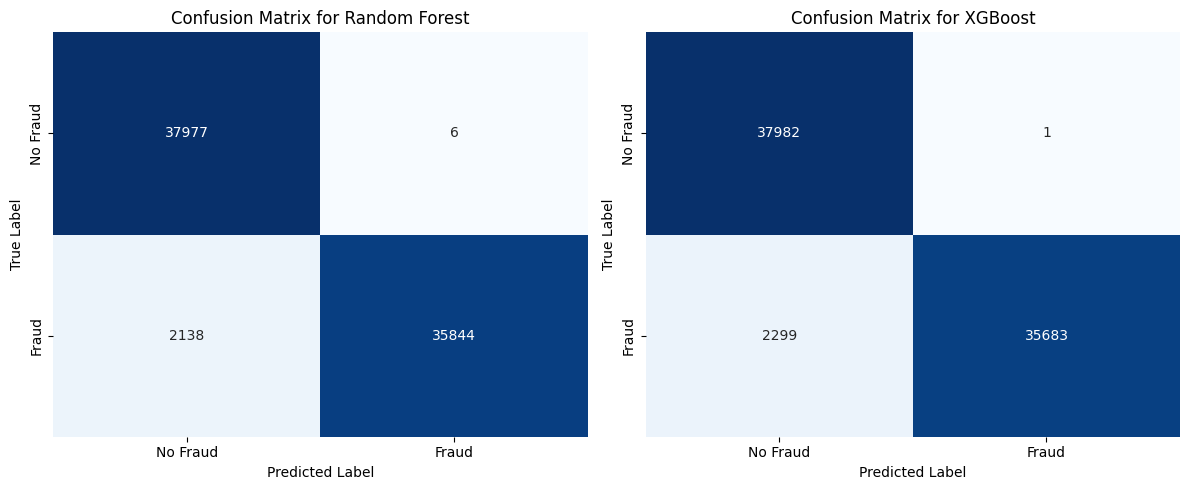

In [20]:
def plot_confusion_matrix_side_by_side(y_true, y_pred, models):
    fig, axes = plt.subplots(1, len(models), figsize=(12, 5))
    
    for ax, (model_name, model) in zip(axes, models.items()):
        cm = confusion_matrix(y_true, model.predict(X_test))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'], ax=ax, cbar=False)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_title(f'Confusion Matrix for {model_name}')
    
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix_side_by_side(y_test, y_pred, models)

In [21]:
best_model = max(models, key=lambda m: recall_score(y_test, models[m].predict(X_test)))
print(f"\n✅ Best Model: {best_model}")


✅ Best Model: Random Forest
